In [1]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt


import torch
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.kernels import NSF_RBF
from gpzoo.gp import SVGP
from gpzoo.likelihoods import Hybrid_NSF
from gpzoo.utilities import train_hybrid, train_hybrid_batched
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
matrix_csv = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_by_gene_goodgenes_noblanks.csv'

In [3]:
annotations_file = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/Merged_clustering_Anannotated.h5ad'

In [4]:
metadata_csv = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_metadata.csv'

In [5]:
df = pd.read_csv(matrix_csv, index_col=0)
meta_df = pd.read_csv(metadata_csv, index_col=0)

In [6]:
meta_df

fov         volume       center_x      center_y          min_x  \
0       NaN   26498.594006    3751.498379   1869.638855    3705.866526   
1       NaN   56901.003220    4070.460352   1897.063230    4027.364662   
2       NaN  159694.223060    3868.161640   1924.793430    3789.672510   
3       NaN   44115.622096    3993.053866   1901.740472    3956.974879   
4       NaN   68099.449761    3745.070088   1933.948772    3703.001893   
...     ...            ...            ...           ...            ...   
844463  NaN   33052.299009  146124.378932  79716.683986  146083.541968   
844464  NaN   41234.756250  145511.601581  79756.418849  145469.434131   
844465  NaN   15724.262249  144881.180956  79759.630573  144857.090651   
844466  NaN   33709.526217  146113.117525  79774.131849  146066.037383   
844467  NaN   19239.775397  145594.202225  79789.018367  145570.413671   

               min_y          max_x         max_y  barcodeCount  
0        1852.063516    3795.907244   1890.068020           NaN  
1        1852.803479    4117.417613   1943.802435           NaN  
2        1860.716249    3953.938938   2004.789954           NaN  
3        1861.464778    4030.900293   1944.210743           NaN  
4        1884.000000    3792.866787   1986.309884           NaN  
...              ...            ...           ...           ...  
844463  79688.219625  146167.337004  79747.157272           NaN  
844464  79727.000000  145556.638368  79793.327305           NaN  
844465  79736.016083  144905.846374  79783.352907           NaN  
844466  79739.795110  146163.456289  79812.542971           NaN  
844467  79756.808407  145619.222396  79822.183948           NaN  

[844468 rows x 9 columns]

In [7]:
df

PDK4  CCL26  CX3CL1  PGLYRP1  CD4  SNAI2  ICAM3  TBX21  FAP  NFKB2  \
cell                                                                         
0        0.0    0.0     0.0      0.0  0.0    0.0    0.0    0.0  0.0    0.0   
1        0.0    0.0     0.0      0.0  0.0    0.0    0.0    0.0  0.0    0.0   
2        0.0    0.0     0.0      0.0  0.0    1.0    0.0    1.0  0.0    0.0   
3        0.0    0.0     0.0      0.0  0.0    0.0    0.0    0.0  0.0    0.0   
4        0.0    0.0     0.0      0.0  0.0    0.0    0.0    0.0  0.0    0.0   
...      ...    ...     ...      ...  ...    ...    ...    ...  ...    ...   
844463   0.0    0.0     0.0      0.0  0.0    0.0    1.0    0.0  2.0    0.0   
844464   0.0    0.0     0.0      0.0  0.0    0.0    2.0    0.0  0.0    0.0   
844465   0.0    0.0     0.0      0.0  0.0    0.0    0.0    0.0  0.0    0.0   
844466   0.0    0.0     0.0      0.0  0.0    0.0    0.0    0.0  0.0    0.0   
844467   0.0    0.0     0.0      0.0  0.0    0.0    0.0    0.0  0.0    0.0   

        ...  IL17A  NOTCH1  TP63  CCL28  TGM2  IDO2  IL13  CD163  IL4  CD19  
cell    ...                                                                  
0       ...    0.0     0.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
1       ...    0.0     0.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
2       ...    0.0     0.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
3       ...    0.0     0.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
4       ...    0.0     0.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
...     ...    ...     ...   ...    ...   ...   ...   ...    ...  ...   ...  
844463  ...    0.0     3.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
844464  ...    0.0     2.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
844465  ...    0.0     0.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
844466  ...    0.0     0.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  
844467  ...    0.0     0.0   0.0    0.0   0.0   0.0   0.0    0.0  0.0   0.0  

[844468 rows x 492 columns]

In [8]:
ad_obj = ad.read_h5ad(annotations_file)

In [9]:
ad_obj

AnnData object with n_obs × n_vars = 754866 × 500
    obs: 'cell', 'n_genes_by_counts', 'total_counts', 'n_counts', 'kmeans11', 'kmeans12', 'kmeans13', 'kmeans14', 'kmeans15', 'kmeans16', 'kmeans17'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'kmeans11_colors', 'kmeans12_colors', 'kmeans13_colors', 'kmeans14_colors', 'kmeans15_colors', 'kmeans16_colors', 'kmeans17_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
X = meta_df.iloc[:, 2:4].values
Y = df.iloc[:,:].values.T

In [11]:
X

array([[  3751.4983792 ,   1869.6388549 ],
       [  4070.46035227,   1897.06323042],
       [  3868.16163983,   1924.79342992],
       ...,
       [144881.18095637,  79759.63057307],
       [146113.11752503,  79774.13184858],
       [145594.20222458,  79789.01836747]])

In [12]:
Y.shape

(492, 844468)

In [13]:
Y.min()

0.0

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [15]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [17]:
nmf_model = NMF(n_components=10, init='random', random_state=0)
W = nmf_model.fit_transform(Y)

mask = W>10
W[~mask] = np.log(np.exp(W[~mask])-1+1e-7)

In [26]:
F = nmf_model.components_

In [18]:
L =10
M = 3000
idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)


kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=100.0)
gp = SVGP(kernel, M=M, jitter=2e-1)
gp.Lu = nn.Parameter(5e-2*torch.eye(M).expand(L, M, M))
# gp.mu = nn.Parameter(5e-1*torch.randn((L, M)))
gp.mu = nn.Parameter(torch.log(torch.tensor(nmf_model.components_, dtype=torch.float)[:,idx]+1e-2))

gp.Z = nn.Parameter(X[idx], requires_grad=False)


model = Hybrid_NSF(gp=gp, y=Y, L=L, non_spatial_factors=L)
model.W = nn.Parameter(torch.tensor(W, dtype=torch.float))
# model.gp.precompute_distance(X, idx)



# if not new_model:
    
#     model.load_state_dict(torch.load('slideseq_nsf', map_location=device))
#     print('Model loaded')
# model.gp.kernel.sigma.requires_grad = False
model.to(device)

Hybrid_NSF(
  (gp): SVGP(
    (kernel): NSF_RBF()
  )
)

In [19]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [20]:
X_train = X.to(device)
Y_train = Y.to(device)

In [31]:
model.to(device)
losses = train_hybrid_batched(model, optimizer, X_train, Y_train, device, steps=100, E=10, batch_size=7000)

  0%|          | 0/100 [00:00<?, ?it/s]

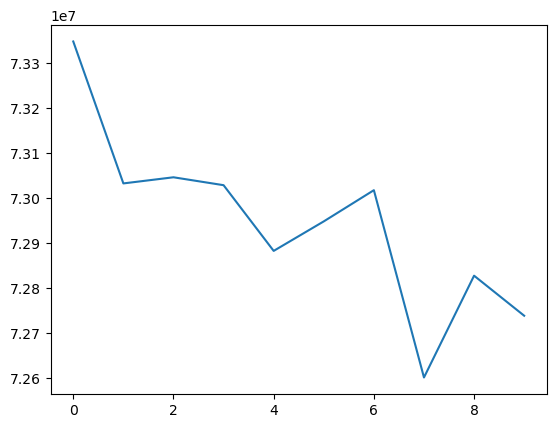

In [22]:
plt.plot(losses)

In [23]:
model.eval()
model.cpu()

idx = torch.multinomial(torch.ones(len(X)), num_samples=10000, replacement=False)

qF, qU, pU = model.gp(X[idx])
loadings = torch.exp(qF.mean).detach().cpu().numpy()
loadings2 = torch.exp(model.mF).detach().cpu().numpy()
del qF, qU, pU
with torch.no_grad():
    if device.type=='cuda':
        torch.cuda.empty_cache()

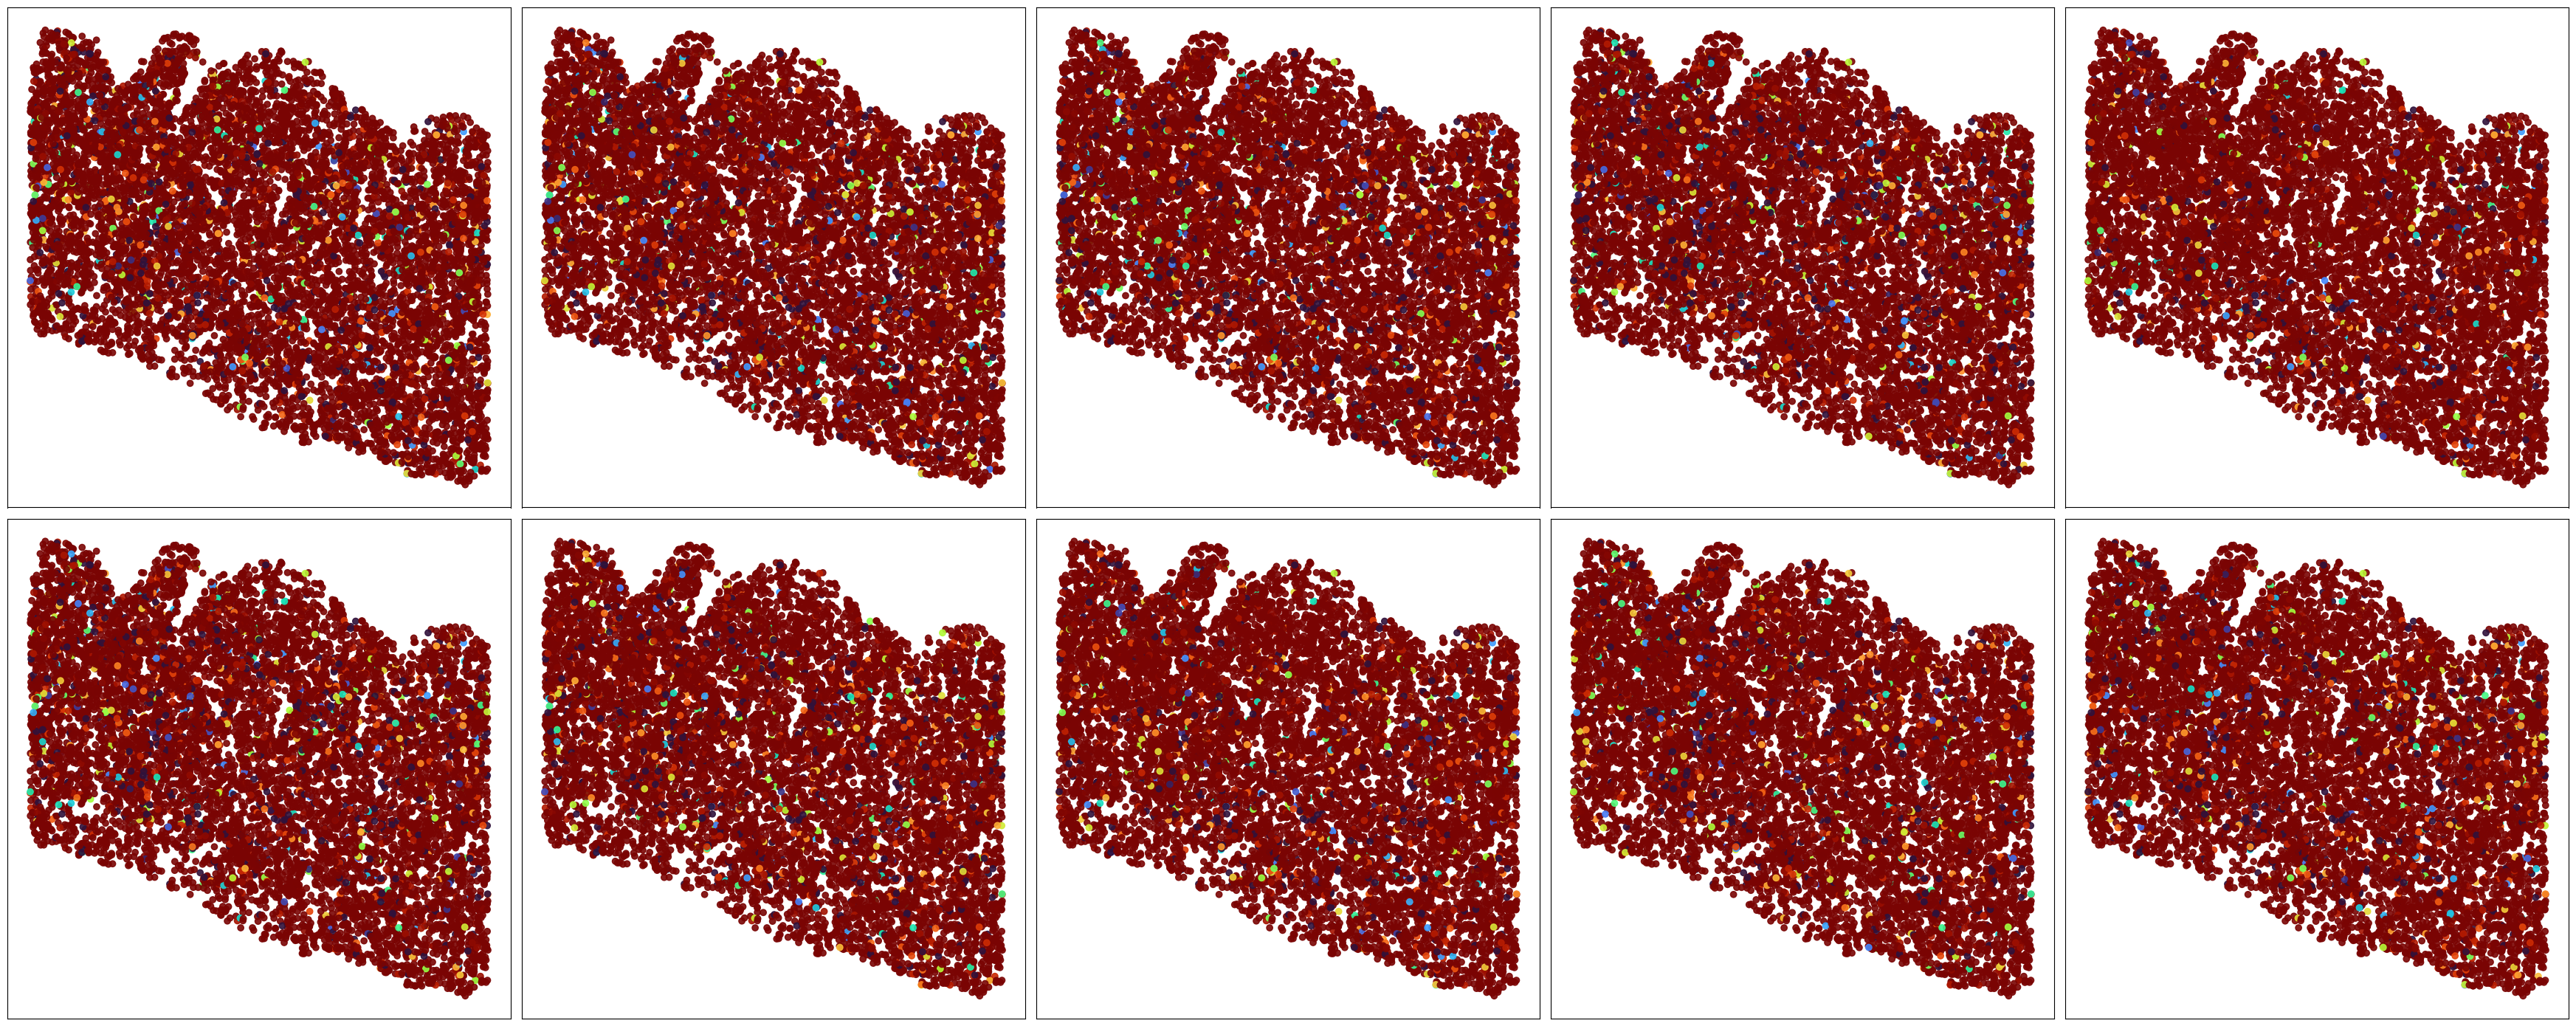

In [24]:
max_val = np.percentile(loadings, 95)
min_val = np.percentile(loadings, 5)


size = 7
plt.figure(figsize=(size*5, size*2), tight_layout=True)
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    plt.scatter(X[idx, 0], X[idx,1], c=loadings[i], vmin=min_val, vmax=max_val, alpha=0.9, cmap='turbo')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])

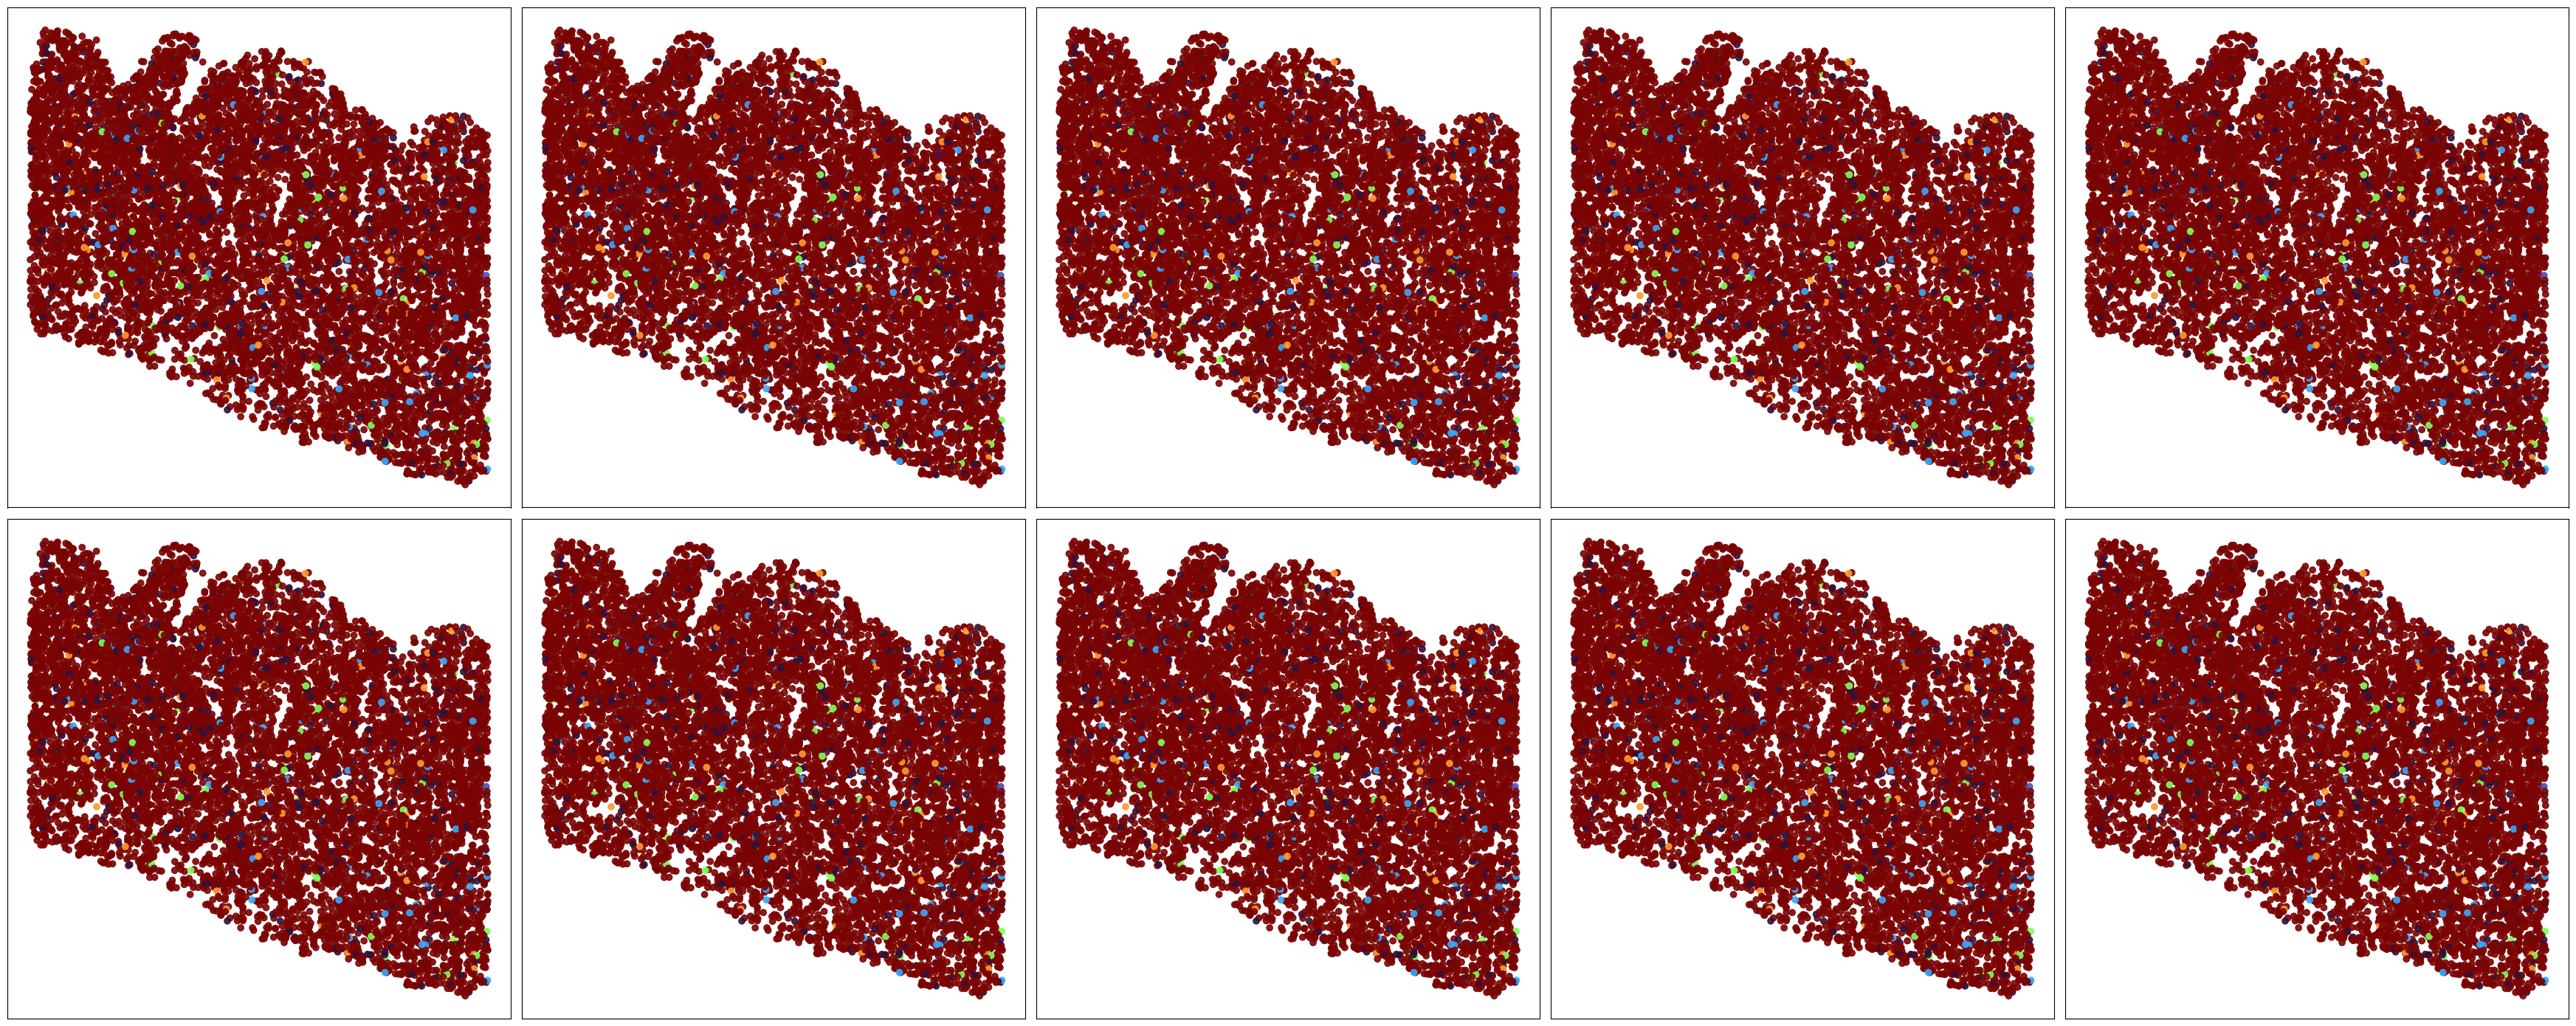

In [25]:
max_val = np.percentile(loadings2, 95)
min_val = np.percentile(loadings2, 5)


size = 7
plt.figure(figsize=(size*5, size*2), tight_layout=True)
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    plt.scatter(X[idx, 0], X[idx,1], c=loadings2[i, idx], vmin=min_val, vmax=max_val, alpha=0.9, cmap='turbo')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])

In [60]:
model.gp.kernel.lengthscale

Parameter containing:
tensor([[[57.7797]],

        [[57.8037]],

        [[57.7238]],

        [[57.8031]],

        [[57.7993]],

        [[57.7774]],

        [[57.7466]],

        [[57.7854]],

        [[57.7730]],

        [[57.7823]]], requires_grad=True)

In [30]:
model.gp.kernel.sigma

Parameter containing:
tensor([[[0.9900]],

        [[0.9900]],

        [[0.9900]],

        [[0.9900]],

        [[0.9900]],

        [[0.9900]],

        [[0.9900]],

        [[0.9900]],

        [[0.9900]],

        [[0.9900]]], requires_grad=True)